In [441]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [442]:
# words = open('names.txt', 'r').read().splitlines()
words = open('rwords.txt', 'r', encoding='utf-8').read().splitlines()
words[:8]

['فنسور',
 'للوصفات',
 'والناشئة',
 'باكاستان',
 'الإنحسار',
 'الراآن',
 'والعنبسي',
 'البواعجا']

In [443]:
words = words[:15000]

In [444]:
chars = sorted(list(set(''.join(words))))
itos =  {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
stoi = {i:s for s,i in itos.items()}
vocab_size = len(itos)

In [445]:
block_size = 10

def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)        
    Y = torch.tensor(Y)
    return X,Y

random.seed(33)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [446]:
n_embd = 10
n_hidden = 500

C = torch.randn(vocab_size, n_embd)
W1 = torch.randn(n_embd* block_size ,n_hidden)  * (5/3) / (n_embd* block_size)**0.5 
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn(n_hidden ,vocab_size) * 0.01
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters= [C , W1 , b1 , W2 , b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

70407

In [447]:
max_steps = 10*100
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch
    ix= torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]     

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    bnmeani =  hpreact.mean(0,keepdim =True)
    bnstdi =  hpreact.std(0,keepdim =True)
    hpreact = bngain * (hpreact -bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnmean_running + 0.001 * bnstdi

    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 1000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad
        
    #track stats
    if i % 10000 == 0:
        print(f"{i}: {loss.item()}")
    lossi.append(loss.log10().item())

0: 3.6310832500457764


In [453]:
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0],-1)
#     hpreact = embcat @ W1 + b1
#     bnmean = hpreact.mean(0,keepdim =True)
#     bnstd = hpreact.std(0,keepdim =True)

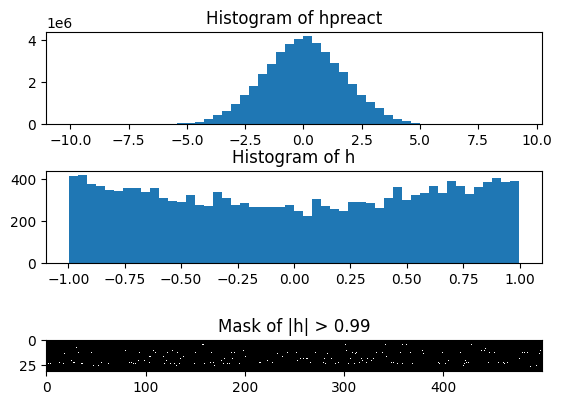

In [431]:
plt.subplot(311)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Histogram of hpreact')


plt.subplot(312)
plt.hist(h.view(-1).tolist(), 50)
plt.title('Histogram of h')


plt.subplot(313)
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('Mask of |h| > 0.99')

plt.subplots_adjust(hspace=0.5) 

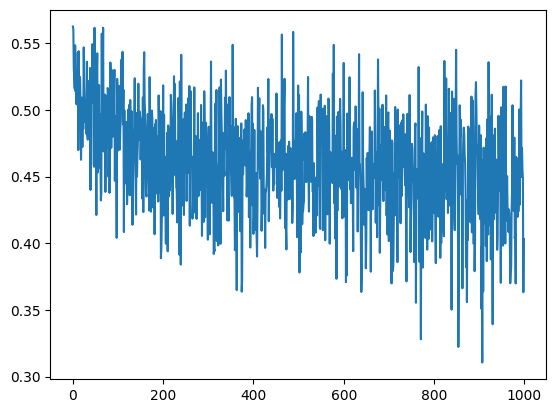

In [421]:
plt.plot(lossi)

In [448]:
@torch.no_grad()
def split_loss(split):
    X,Y = {
        'train': (Xtr,Ytr),
        'val':(Xdev, Ydev),
        'test': (Xte,Yte)
    }[split]

    emb = C[X]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    hpreact = (bngain * (hpreact - bnmean) / bnstd)+ bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"{split}, loss = {loss}")
    
split_loss('train')
split_loss('val')

train, loss = 3.736093282699585
val, loss = 3.7373266220092773


In [449]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # Shape: (1, 3, 10)
        embcat = emb.view(emb.shape[0], -1)  # Shape: (1, 30)
        h = torch.tanh(embcat @ W1 + b1)  # Shape: (1, 200)
        logits = h @ W2 + b2  # Shape:| (1, vocab_size)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1)
        context = context[1:] + [ix.item()]  # Update context
        out.append(ix.item())
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

سشبطبهنهاعصأحزثهش.
سرركونهاة.
لحيكورجيان.
جلثوطالسهجراصهاقاس.
وشتحدفبهمنيلقوت.
أدنأنمآرذؤي.
للرحرجياح.
لمسنررمهمض.
للأقردارادرعااندزسويع.
ملعرعفرتشؤدفجمخذالخةارلو.
فسدمبلفءازالتقملرضعهرت.
بولجسيبيءمنل.
للسقمنميمخطيطن.
سرسشحتكماض.
صلجتركنلاتهذلع.
فلحبدنالتقئفيغثهظرتويذطد.
لببرقهباضهغدمدشغإحآرلكةاخر.
لحسرحرارم.
وبالعفدعسأآشؤهضواؤامعجتةفن.
سبفنحمصنورنوصمت.


tensor(-0.0056) tensor(0.9995)
tensor(-0.0002) tensor(0.9846)


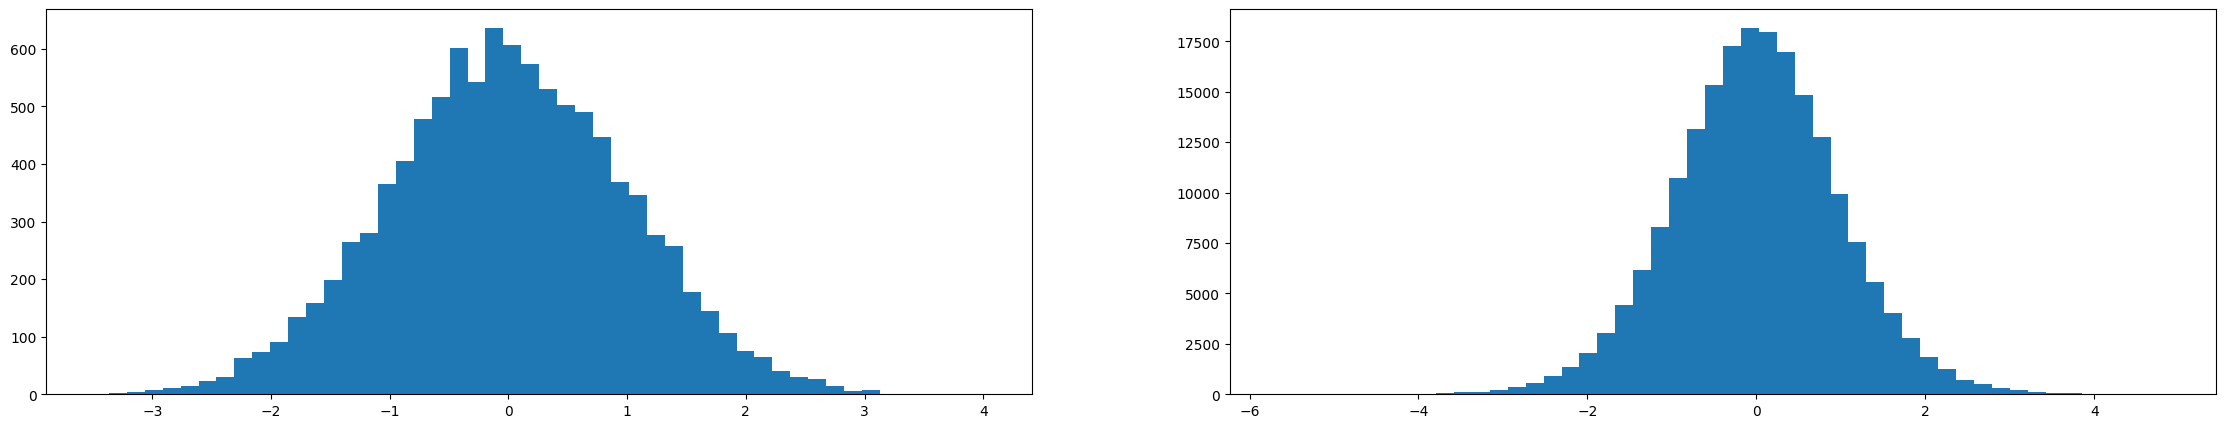

In [450]:
# # logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
# logits = torch.randn(4)
# probs = torch.softmax(logits,dim=0)
# loss = - probs[2].log()
# probs , loss


x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w 

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(28,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50);

In [425]:
# ### the inital loss
# to fix we had to make the logits samller 
# to be close to the expected loss (1/27) 
# we did this by makeing w2 and b2 smaller

# ### fix the sattuerd tanh
# we fix it by making the values in the pre activation layer smaller 
# because if they too high tanh will be 1 or -1
# if it is 1 or -1 the gradient will be satrt vanishit..
# and if u think about it when u cahnge the input the output wont really change
# beacause we are in the falt region of tanh ...

## batchNorm
